## Deep Learning Version , oversampled

In [1]:
#imports
import time
start_time = time.time()
import numpy as np
from matplotlib import pyplot as plt
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.metrics import binary_accuracy
#from keras.utils import np_utils
print("--- %s seconds ---" % (time.time() - start_time))

Using TensorFlow backend.


--- 9.540265560150146 seconds ---


In [2]:
# import datasets with time taken!
#smoll
start_time = time.time()
smoll = np.loadtxt("/home/willett/NeutrinoData/small_CNN_input_processed.txt", comments='#')
print("--- %s seconds ---" % (time.time() - start_time))
print(smoll.shape)

""" # commented out to save computation

#and the full
start_time = time.time()
fll = np.loadtxt("/home/willett/NeutrinoData/full_CNN_input_processed.txt", comments='#')
print("--- %s seconds ---" % (time.time() - start_time))
print(fll.shape)
"""

""" # commented out to save computation
#and the full
start_time = time.time()
fll = np.loadtxt("/home/willett/NeutrinoData/test_CNN_input_processed.txt", comments='#')
print("--- %s seconds ---" % (time.time() - start_time))
print(fll.shape)
"""

# extract title
pls = open("/home/willett/NeutrinoData/small_CNN_input_processed.txt", "r")
title = pls.readline()
title = title[2:-1]
print(title)

--- 0.09120965003967285 seconds ---
(247, 21)
 FirstLayer  LastLayer NHits  AverageZP Thrust  PID_Angle  PID_Front  PID_LLR_M  FirstLayer  LastLayer  NHits_Low  AverageZP  Thrust_Lo  PID_Angle  PID_Front  PID_LLR_M  Energy_As  Angle_Bet  Distance_Bet   Sig   Bg


In [3]:
# creating a dataset switch, change what UsedData is to change CNN
UD = smoll # Used Data = <dataset>
UDLength = UD.shape[0]
print("shape: ",UD.shape,"\nsize: ", UD.size," \nlength: ", UDLength)

# dataset is expected in this format:
# FirstLayer  LastLayer NHits  AverageZP Thrust  PID_Angle  PID_Front  PID_LLR_M
#FirstLayer  LastLayer  NHits_Low  AverageZP  Thrust_Lo  PID_Angle  PID_Front  PID_LLR_M  
#Energy_As  Angle_Bet  Distance_Bet   Sig   Bg

# with Sig and Bg expected as one hot vectors.

shape:  (247, 21) 
size:  5187  
length:  247


In [4]:
# splitting X = dataset , Y = one hot vectors
X = UD[:,0:-2]
Y = UD[:,-2:1000]
print("X shape: ",X.shape,"\nY shape: ", Y.shape)

# they will be split into testing and training at compile

X shape:  (247, 19) 
Y shape:  (247, 2)


In [5]:
# inevitable bias removal... by oversampling
# using a 50% oversampling ratio, because i want to ! (no citation)

#how long?
start_time = time.time()

SigI = np.where(Y[:,0] == 1)[0] 
BgI= np.where(Y[:,0] == 0)[0]
SigN = SigI.size       # how much signal there is
BgN = BgI.size         # how much background there is
Multip = int(BgN/SigN) # how much more signal event copies needed for ~50%
print(" signal and background event number: ",SigI.size,BgI.size,"\n number more needed:",Multip)
SNratio =  (100*SigN)/(SigN + BgN)
print("initial Signal to Noise ratio: ",SNratio,"% signal")

#im going to reconstruct the arrays of signal events, background events, then add them together and shuffle!

XSig = X[SigI]
XBg = X[BgI]
YSig = Y[SigI]
YBg = Y[BgI]
#print(XSig.shape,XBg.shape, YSig.shape, YBg.shape) # these are the events of each type.

# this is the array of signal repreated (tiled) multip times.
YSigM = np.transpose(np.tile(np.transpose(YSig), Multip))
XSigM = np.transpose(np.tile(np.transpose(XSig), Multip)) 
print( XSigM.shape, YSigM.shape)

#adding arrays together and then shuffling:
X2 = np.concatenate((XBg,XSigM))
Y2 = np.concatenate((YBg,YSigM))
print(X2.shape, Y2.shape)

#shuffling
print("these arrays should be different vertically, to ensure shuffle succesful:")
print(X2[0:3,0],Y2[0:3,0])
np.random.shuffle(X2)
np.random.shuffle(Y2)
print(X2[0:3,0],Y2[0:3,0])

#final ratio:
NewSigN = YSigM.shape[0]
SNRatioNew = (100*YSigM.shape[0]) / (YSigM.shape[0] + BgN)
print("final Signal Noise ratio: ",SNRatioNew,"% signal")

print("--- %s seconds ---" % (time.time() - start_time))


 signal and background event number:  10 237 
 number more needed: 23
initial Signal to Noise ratio:  4.048582995951417 % signal
(230, 19) (230, 2)
(467, 19) (467, 2)
these arrays should be different vertically, to ensure shuffle succesful:
[0.00829848 0.0039091  0.00049919] [0. 0. 0.]
[0.00196223 0.01925798 0.00030634] [1. 1. 0.]
final Signal Noise ratio:  49.25053533190578 % signal
--- 0.01849079132080078 seconds ---


In [6]:
print(X2.shape)
X3 = np.expand_dims(X2, axis=2)
print(X3.shape)


(467, 19)
(467, 19, 1)


In [7]:


#neural network architecture:
model = Sequential()

# set variables:
width = 15 #--number on nodes in the layer
DR = 0.5 #--fraction of nodes dropped during training
AT = "sigmoid" #--activation type for dense layers
UB = True #--use bias vectors 
InDim = (X3.shape[1],X3.shape[2] ) #--input shape of single sample (tuple)

#construction:
start_time = time.time() # how long does it take?
model.add(Dense(width,activation=AT, use_bias=UB, input_shape=(19,1) )) # input layer and 1
model.add(Dropout(DR))
model.add(Dense(width,activation=AT, use_bias=UB )) # 2
model.add(Dropout(DR))
model.add(Dense(width,activation=AT, use_bias=UB )) # 3
model.add(Dropout(DR))
model.add(Dense(width,activation=AT, use_bias=UB )) # 4
model.add(Dropout(DR))

#Because this one is deep:
model.add(Dense(width,activation=AT, use_bias=UB )) # 3
model.add(Dropout(DR))
model.add(Dense(width,activation=AT, use_bias=UB )) # 4
model.add(Dropout(DR))
model.add(Dense(width,activation=AT, use_bias=UB )) # 3
model.add(Dropout(DR))
model.add(Dense(width,activation=AT, use_bias=UB )) # 4
model.add(Dropout(DR))



model.add(Flatten())  # reduce dimensionality of the input data for output

model.add(Dense(2, activation="softmax", use_bias=UB)) # output layer softmax recommended 
#(classification mutually excluive + softmax differentiable for optimizing)
# -> https://www.quora.com/Artificial-Neural-Networks-Why-do-we-use-softmax-function-for-output-layer
print("--- %s seconds ---" % (time.time() - start_time))



--- 0.46912074089050293 seconds ---


In [8]:
# Apply regularizer if overfitting! ^

# binary_crossentropy is the best according to https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/
# adam is best for me according to https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f

In [12]:
# compile model:
start_time = time.time() # how long does it take?
model.compile(optimizer='adadelta',            
              loss='binary_crossentropy',               
              metrics=['accuracy', 'binary_accuracy' ])

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.06549406051635742 seconds ---


In [13]:
# Train the model, iterating on the data in batches of 32 samples

start_time = time.time()             # how long does it take?
history = model.fit(X3,              # the (now oversampled) dataset
          Y2,                        #true or false values for the dataset 
          epochs=1000,                 #number of iteration over data
          batch_size=32,             #number of trainings between tests
          verbose=1,                 #prints one line per epoch of progress bar
          validation_split=0.1 )     #ratio of test to train

print("--- %s seconds ---" % (time.time() - start_time))

Train on 420 samples, validate on 47 samples
Epoch 1/1000
420/420 [==============================] - 1s 3ms/step - loss: 0.6943 - acc: 0.4905 - binary_accuracy: 0.4905 - val_loss: 0.6952 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 2/1000
420/420 [==============================] - 0s 450us/step - loss: 0.6916 - acc: 0.5071 - binary_accuracy: 0.5071 - val_loss: 0.6957 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 3/1000
420/420 [==============================] - 0s 389us/step - loss: 0.6944 - acc: 0.4476 - binary_accuracy: 0.4476 - val_loss: 0.6960 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 4/1000
420/420 [==============================] - 0s 441us/step - loss: 0.6925 - acc: 0.5333 - binary_accuracy: 0.5333 - val_loss: 0.6952 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 5/1000
420/420 [==============================] - 0s 360us/step - loss: 0.6954 - acc: 0.4881 - binary_accuracy: 0.4881 - val_loss: 0.6955 - val_acc: 0.4043 - val_binary_accuracy: 0.40

420/420 [==============================] - 0s 458us/step - loss: 0.6937 - acc: 0.5095 - binary_accuracy: 0.5095 - val_loss: 0.6940 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 44/1000
420/420 [==============================] - 0s 337us/step - loss: 0.6922 - acc: 0.4929 - binary_accuracy: 0.4929 - val_loss: 0.6943 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 45/1000
420/420 [==============================] - 0s 284us/step - loss: 0.6932 - acc: 0.4500 - binary_accuracy: 0.4500 - val_loss: 0.6942 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 46/1000
420/420 [==============================] - 0s 356us/step - loss: 0.6962 - acc: 0.4643 - binary_accuracy: 0.4643 - val_loss: 0.6938 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 47/1000
420/420 [==============================] - 0s 591us/step - loss: 0.6939 - acc: 0.5071 - binary_accuracy: 0.5071 - val_loss: 0.6935 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 48/1000
420/420 [==========================

420/420 [==============================] - 0s 398us/step - loss: 0.6925 - acc: 0.5167 - binary_accuracy: 0.5167 - val_loss: 0.6929 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 86/1000
420/420 [==============================] - 0s 392us/step - loss: 0.6939 - acc: 0.5310 - binary_accuracy: 0.5310 - val_loss: 0.6926 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 87/1000
420/420 [==============================] - 0s 593us/step - loss: 0.6944 - acc: 0.4905 - binary_accuracy: 0.4905 - val_loss: 0.6923 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 88/1000
420/420 [==============================] - 0s 670us/step - loss: 0.6949 - acc: 0.4857 - binary_accuracy: 0.4857 - val_loss: 0.6928 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 89/1000
420/420 [==============================] - 0s 678us/step - loss: 0.6935 - acc: 0.5405 - binary_accuracy: 0.5405 - val_loss: 0.6925 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 90/1000
420/420 [==========================

420/420 [==============================] - 0s 679us/step - loss: 0.6938 - acc: 0.5024 - binary_accuracy: 0.5024 - val_loss: 0.6935 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 128/1000
420/420 [==============================] - 0s 713us/step - loss: 0.6915 - acc: 0.5167 - binary_accuracy: 0.5167 - val_loss: 0.6938 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 129/1000
420/420 [==============================] - 0s 718us/step - loss: 0.6925 - acc: 0.4905 - binary_accuracy: 0.4905 - val_loss: 0.6936 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 130/1000
420/420 [==============================] - 0s 581us/step - loss: 0.6941 - acc: 0.4905 - binary_accuracy: 0.4905 - val_loss: 0.6932 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 131/1000
420/420 [==============================] - 0s 644us/step - loss: 0.6950 - acc: 0.5095 - binary_accuracy: 0.5095 - val_loss: 0.6932 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 132/1000
420/420 [=====================

420/420 [==============================] - 0s 571us/step - loss: 0.6937 - acc: 0.4762 - binary_accuracy: 0.4762 - val_loss: 0.6954 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 170/1000
420/420 [==============================] - 0s 622us/step - loss: 0.6935 - acc: 0.5048 - binary_accuracy: 0.5048 - val_loss: 0.6954 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 171/1000
420/420 [==============================] - 0s 583us/step - loss: 0.6931 - acc: 0.4976 - binary_accuracy: 0.4976 - val_loss: 0.6958 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 172/1000
420/420 [==============================] - 0s 541us/step - loss: 0.6925 - acc: 0.5119 - binary_accuracy: 0.5119 - val_loss: 0.6960 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 173/1000
420/420 [==============================] - 0s 525us/step - loss: 0.6941 - acc: 0.5000 - binary_accuracy: 0.5000 - val_loss: 0.6956 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 174/1000
420/420 [=====================

420/420 [==============================] - 0s 276us/step - loss: 0.6934 - acc: 0.5071 - binary_accuracy: 0.5071 - val_loss: 0.6947 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 212/1000
420/420 [==============================] - 0s 293us/step - loss: 0.6940 - acc: 0.4976 - binary_accuracy: 0.4976 - val_loss: 0.6943 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 213/1000
420/420 [==============================] - 0s 283us/step - loss: 0.6936 - acc: 0.5024 - binary_accuracy: 0.5024 - val_loss: 0.6946 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 214/1000
420/420 [==============================] - 0s 353us/step - loss: 0.6940 - acc: 0.4762 - binary_accuracy: 0.4762 - val_loss: 0.6942 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 215/1000
420/420 [==============================] - 0s 389us/step - loss: 0.6931 - acc: 0.4833 - binary_accuracy: 0.4833 - val_loss: 0.6942 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 216/1000
420/420 [=====================

420/420 [==============================] - 0s 649us/step - loss: 0.6936 - acc: 0.5048 - binary_accuracy: 0.5048 - val_loss: 0.6936 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 254/1000
420/420 [==============================] - 0s 679us/step - loss: 0.6929 - acc: 0.4929 - binary_accuracy: 0.4929 - val_loss: 0.6939 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 255/1000
420/420 [==============================] - 0s 536us/step - loss: 0.6937 - acc: 0.4762 - binary_accuracy: 0.4762 - val_loss: 0.6943 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 256/1000
420/420 [==============================] - 0s 454us/step - loss: 0.6926 - acc: 0.5167 - binary_accuracy: 0.5167 - val_loss: 0.6947 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 257/1000
420/420 [==============================] - 0s 678us/step - loss: 0.6928 - acc: 0.5048 - binary_accuracy: 0.5048 - val_loss: 0.6942 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 258/1000
420/420 [=====================

420/420 [==============================] - 0s 524us/step - loss: 0.6931 - acc: 0.4929 - binary_accuracy: 0.4929 - val_loss: 0.6920 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 296/1000
420/420 [==============================] - 0s 663us/step - loss: 0.6942 - acc: 0.4929 - binary_accuracy: 0.4929 - val_loss: 0.6921 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 297/1000
420/420 [==============================] - 0s 727us/step - loss: 0.6920 - acc: 0.4881 - binary_accuracy: 0.4881 - val_loss: 0.6925 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 298/1000
420/420 [==============================] - 0s 560us/step - loss: 0.6927 - acc: 0.4857 - binary_accuracy: 0.4857 - val_loss: 0.6928 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 299/1000
420/420 [==============================] - 0s 645us/step - loss: 0.6940 - acc: 0.4905 - binary_accuracy: 0.4905 - val_loss: 0.6932 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 300/1000
420/420 [=====================

420/420 [==============================] - 0s 527us/step - loss: 0.6935 - acc: 0.5048 - binary_accuracy: 0.5048 - val_loss: 0.6954 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 338/1000
420/420 [==============================] - 0s 673us/step - loss: 0.6944 - acc: 0.5214 - binary_accuracy: 0.5214 - val_loss: 0.6948 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 339/1000
420/420 [==============================] - 0s 700us/step - loss: 0.6930 - acc: 0.5095 - binary_accuracy: 0.5095 - val_loss: 0.6948 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 340/1000
420/420 [==============================] - 0s 782us/step - loss: 0.6946 - acc: 0.4810 - binary_accuracy: 0.4810 - val_loss: 0.6947 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 341/1000
420/420 [==============================] - 0s 639us/step - loss: 0.6937 - acc: 0.4857 - binary_accuracy: 0.4857 - val_loss: 0.6944 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 342/1000
420/420 [=====================

420/420 [==============================] - 0s 678us/step - loss: 0.6930 - acc: 0.4905 - binary_accuracy: 0.4905 - val_loss: 0.6924 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 380/1000
420/420 [==============================] - 0s 674us/step - loss: 0.6927 - acc: 0.5048 - binary_accuracy: 0.5048 - val_loss: 0.6922 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 381/1000
420/420 [==============================] - 0s 532us/step - loss: 0.6937 - acc: 0.4667 - binary_accuracy: 0.4667 - val_loss: 0.6920 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 382/1000
420/420 [==============================] - 0s 680us/step - loss: 0.6936 - acc: 0.5167 - binary_accuracy: 0.5167 - val_loss: 0.6921 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 383/1000
420/420 [==============================] - 0s 591us/step - loss: 0.6925 - acc: 0.5333 - binary_accuracy: 0.5333 - val_loss: 0.6922 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 384/1000
420/420 [=====================

420/420 [==============================] - 0s 522us/step - loss: 0.6935 - acc: 0.4857 - binary_accuracy: 0.4857 - val_loss: 0.6947 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 422/1000
420/420 [==============================] - 0s 323us/step - loss: 0.6937 - acc: 0.5071 - binary_accuracy: 0.5071 - val_loss: 0.6943 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 423/1000
420/420 [==============================] - 0s 419us/step - loss: 0.6954 - acc: 0.4690 - binary_accuracy: 0.4690 - val_loss: 0.6942 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 424/1000
420/420 [==============================] - 0s 345us/step - loss: 0.6942 - acc: 0.5024 - binary_accuracy: 0.5024 - val_loss: 0.6942 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 425/1000
420/420 [==============================] - 0s 349us/step - loss: 0.6921 - acc: 0.5286 - binary_accuracy: 0.5286 - val_loss: 0.6941 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 426/1000
420/420 [=====================

420/420 [==============================] - 0s 592us/step - loss: 0.6932 - acc: 0.4929 - binary_accuracy: 0.4929 - val_loss: 0.6937 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 464/1000
420/420 [==============================] - 0s 474us/step - loss: 0.6944 - acc: 0.4976 - binary_accuracy: 0.4976 - val_loss: 0.6940 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 465/1000
420/420 [==============================] - 0s 395us/step - loss: 0.6928 - acc: 0.5238 - binary_accuracy: 0.5238 - val_loss: 0.6937 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 466/1000
420/420 [==============================] - 0s 379us/step - loss: 0.6939 - acc: 0.4810 - binary_accuracy: 0.4810 - val_loss: 0.6937 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 467/1000
420/420 [==============================] - 0s 513us/step - loss: 0.6925 - acc: 0.5024 - binary_accuracy: 0.5024 - val_loss: 0.6933 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 468/1000
420/420 [=====================

420/420 [==============================] - 0s 416us/step - loss: 0.6939 - acc: 0.5071 - binary_accuracy: 0.5071 - val_loss: 0.6941 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 506/1000
420/420 [==============================] - 0s 445us/step - loss: 0.6922 - acc: 0.5286 - binary_accuracy: 0.5286 - val_loss: 0.6938 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 507/1000
420/420 [==============================] - 0s 637us/step - loss: 0.6934 - acc: 0.4810 - binary_accuracy: 0.4810 - val_loss: 0.6942 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 508/1000
420/420 [==============================] - 0s 499us/step - loss: 0.6928 - acc: 0.5238 - binary_accuracy: 0.5238 - val_loss: 0.6945 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 509/1000
420/420 [==============================] - 0s 458us/step - loss: 0.6932 - acc: 0.4952 - binary_accuracy: 0.4952 - val_loss: 0.6945 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 510/1000
420/420 [=====================

420/420 [==============================] - 0s 389us/step - loss: 0.6924 - acc: 0.5024 - binary_accuracy: 0.5024 - val_loss: 0.6941 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 548/1000
420/420 [==============================] - 0s 585us/step - loss: 0.6927 - acc: 0.4976 - binary_accuracy: 0.4976 - val_loss: 0.6941 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 549/1000
420/420 [==============================] - 0s 727us/step - loss: 0.6946 - acc: 0.5119 - binary_accuracy: 0.5119 - val_loss: 0.6938 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 550/1000
420/420 [==============================] - 0s 675us/step - loss: 0.6935 - acc: 0.5000 - binary_accuracy: 0.5000 - val_loss: 0.6940 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 551/1000
420/420 [==============================] - 0s 568us/step - loss: 0.6932 - acc: 0.4952 - binary_accuracy: 0.4952 - val_loss: 0.6944 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 552/1000
420/420 [=====================

420/420 [==============================] - 0s 586us/step - loss: 0.6929 - acc: 0.5024 - binary_accuracy: 0.5024 - val_loss: 0.6939 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 590/1000
420/420 [==============================] - 0s 721us/step - loss: 0.6918 - acc: 0.5095 - binary_accuracy: 0.5095 - val_loss: 0.6943 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 591/1000
420/420 [==============================] - 0s 728us/step - loss: 0.6934 - acc: 0.4786 - binary_accuracy: 0.4786 - val_loss: 0.6942 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 592/1000
420/420 [==============================] - 0s 602us/step - loss: 0.6932 - acc: 0.5095 - binary_accuracy: 0.5095 - val_loss: 0.6942 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 593/1000
420/420 [==============================] - 0s 595us/step - loss: 0.6934 - acc: 0.4929 - binary_accuracy: 0.4929 - val_loss: 0.6947 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 594/1000
420/420 [=====================

420/420 [==============================] - 0s 571us/step - loss: 0.6928 - acc: 0.5167 - binary_accuracy: 0.5167 - val_loss: 0.6944 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 632/1000
420/420 [==============================] - 0s 477us/step - loss: 0.6920 - acc: 0.5119 - binary_accuracy: 0.5119 - val_loss: 0.6946 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 633/1000
420/420 [==============================] - 0s 641us/step - loss: 0.6928 - acc: 0.4976 - binary_accuracy: 0.4976 - val_loss: 0.6946 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 634/1000
420/420 [==============================] - 0s 705us/step - loss: 0.6930 - acc: 0.5143 - binary_accuracy: 0.5143 - val_loss: 0.6945 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 635/1000
420/420 [==============================] - 0s 590us/step - loss: 0.6949 - acc: 0.4881 - binary_accuracy: 0.4881 - val_loss: 0.6948 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 636/1000
420/420 [=====================

420/420 [==============================] - 0s 540us/step - loss: 0.6939 - acc: 0.4762 - binary_accuracy: 0.4762 - val_loss: 0.6943 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 674/1000
420/420 [==============================] - 0s 390us/step - loss: 0.6930 - acc: 0.4976 - binary_accuracy: 0.4976 - val_loss: 0.6938 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 675/1000
420/420 [==============================] - 0s 472us/step - loss: 0.6936 - acc: 0.4857 - binary_accuracy: 0.4857 - val_loss: 0.6935 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 676/1000
420/420 [==============================] - 0s 509us/step - loss: 0.6922 - acc: 0.4857 - binary_accuracy: 0.4857 - val_loss: 0.6939 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 677/1000
420/420 [==============================] - 0s 513us/step - loss: 0.6927 - acc: 0.4786 - binary_accuracy: 0.4786 - val_loss: 0.6933 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 678/1000
420/420 [=====================

420/420 [==============================] - 0s 500us/step - loss: 0.6935 - acc: 0.4690 - binary_accuracy: 0.4690 - val_loss: 0.6929 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 716/1000
420/420 [==============================] - 0s 800us/step - loss: 0.6929 - acc: 0.4857 - binary_accuracy: 0.4857 - val_loss: 0.6932 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 717/1000
420/420 [==============================] - 0s 539us/step - loss: 0.6935 - acc: 0.4738 - binary_accuracy: 0.4738 - val_loss: 0.6935 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 718/1000
420/420 [==============================] - 0s 653us/step - loss: 0.6935 - acc: 0.5119 - binary_accuracy: 0.5119 - val_loss: 0.6936 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 719/1000
420/420 [==============================] - 0s 496us/step - loss: 0.6926 - acc: 0.4976 - binary_accuracy: 0.4976 - val_loss: 0.6940 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 720/1000
420/420 [=====================

420/420 [==============================] - 0s 581us/step - loss: 0.6940 - acc: 0.4857 - binary_accuracy: 0.4857 - val_loss: 0.6940 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 758/1000
420/420 [==============================] - 0s 667us/step - loss: 0.6930 - acc: 0.5238 - binary_accuracy: 0.5238 - val_loss: 0.6936 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 759/1000
420/420 [==============================] - 0s 674us/step - loss: 0.6936 - acc: 0.4881 - binary_accuracy: 0.4881 - val_loss: 0.6936 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 760/1000
420/420 [==============================] - 0s 791us/step - loss: 0.6932 - acc: 0.5286 - binary_accuracy: 0.5286 - val_loss: 0.6941 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 761/1000
420/420 [==============================] - 0s 653us/step - loss: 0.6938 - acc: 0.4952 - binary_accuracy: 0.4952 - val_loss: 0.6938 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 762/1000
420/420 [=====================

420/420 [==============================] - 0s 502us/step - loss: 0.6934 - acc: 0.4810 - binary_accuracy: 0.4810 - val_loss: 0.6923 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 800/1000
420/420 [==============================] - 0s 401us/step - loss: 0.6946 - acc: 0.4595 - binary_accuracy: 0.4595 - val_loss: 0.6921 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 801/1000
420/420 [==============================] - 0s 598us/step - loss: 0.6945 - acc: 0.4929 - binary_accuracy: 0.4929 - val_loss: 0.6922 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 802/1000
420/420 [==============================] - 0s 695us/step - loss: 0.6934 - acc: 0.5095 - binary_accuracy: 0.5095 - val_loss: 0.6920 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 803/1000
420/420 [==============================] - 0s 666us/step - loss: 0.6934 - acc: 0.4905 - binary_accuracy: 0.4905 - val_loss: 0.6921 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 804/1000
420/420 [=====================

420/420 [==============================] - 0s 602us/step - loss: 0.6929 - acc: 0.5000 - binary_accuracy: 0.5000 - val_loss: 0.6941 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 842/1000
420/420 [==============================] - 0s 677us/step - loss: 0.6933 - acc: 0.4976 - binary_accuracy: 0.4976 - val_loss: 0.6938 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 843/1000
420/420 [==============================] - 0s 686us/step - loss: 0.6942 - acc: 0.4929 - binary_accuracy: 0.4929 - val_loss: 0.6941 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 844/1000
420/420 [==============================] - 0s 674us/step - loss: 0.6942 - acc: 0.4857 - binary_accuracy: 0.4857 - val_loss: 0.6938 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 845/1000
420/420 [==============================] - 0s 720us/step - loss: 0.6930 - acc: 0.5238 - binary_accuracy: 0.5238 - val_loss: 0.6941 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 846/1000
420/420 [=====================

Epoch 883/1000
420/420 [==============================] - 0s 542us/step - loss: 0.6928 - acc: 0.5238 - binary_accuracy: 0.5238 - val_loss: 0.6927 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 884/1000
420/420 [==============================] - 0s 699us/step - loss: 0.6935 - acc: 0.4738 - binary_accuracy: 0.4738 - val_loss: 0.6928 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 885/1000
420/420 [==============================] - 0s 571us/step - loss: 0.6938 - acc: 0.4571 - binary_accuracy: 0.4571 - val_loss: 0.6933 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 886/1000
420/420 [==============================] - 0s 515us/step - loss: 0.6936 - acc: 0.5071 - binary_accuracy: 0.5071 - val_loss: 0.6930 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 887/1000
420/420 [==============================] - 0s 652us/step - loss: 0.6929 - acc: 0.5071 - binary_accuracy: 0.5071 - val_loss: 0.6927 - val_acc: 0.5957 - val_binary_accuracy: 0.5957
Epoch 888/1000
420/420 [======

420/420 [==============================] - 0s 503us/step - loss: 0.6933 - acc: 0.5095 - binary_accuracy: 0.5095 - val_loss: 0.6945 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 926/1000
420/420 [==============================] - 0s 469us/step - loss: 0.6933 - acc: 0.5095 - binary_accuracy: 0.5095 - val_loss: 0.6942 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 927/1000
420/420 [==============================] - 0s 530us/step - loss: 0.6927 - acc: 0.4976 - binary_accuracy: 0.4976 - val_loss: 0.6945 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 928/1000
420/420 [==============================] - 0s 684us/step - loss: 0.6929 - acc: 0.4929 - binary_accuracy: 0.4929 - val_loss: 0.6948 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 929/1000
420/420 [==============================] - 0s 414us/step - loss: 0.6929 - acc: 0.4952 - binary_accuracy: 0.4952 - val_loss: 0.6944 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 930/1000
420/420 [=====================

420/420 [==============================] - 0s 369us/step - loss: 0.6925 - acc: 0.5333 - binary_accuracy: 0.5333 - val_loss: 0.6947 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 968/1000
420/420 [==============================] - 0s 519us/step - loss: 0.6929 - acc: 0.5167 - binary_accuracy: 0.5167 - val_loss: 0.6950 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 969/1000
420/420 [==============================] - 0s 722us/step - loss: 0.6929 - acc: 0.5095 - binary_accuracy: 0.5095 - val_loss: 0.6949 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 970/1000
420/420 [==============================] - 0s 654us/step - loss: 0.6939 - acc: 0.4976 - binary_accuracy: 0.4976 - val_loss: 0.6949 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 971/1000
420/420 [==============================] - 0s 691us/step - loss: 0.6930 - acc: 0.4881 - binary_accuracy: 0.4881 - val_loss: 0.6952 - val_acc: 0.4043 - val_binary_accuracy: 0.4043
Epoch 972/1000
420/420 [=====================

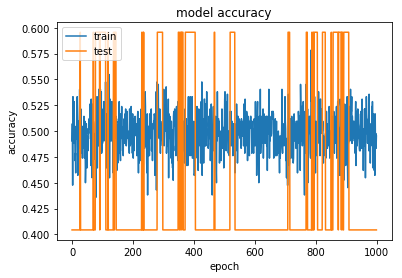

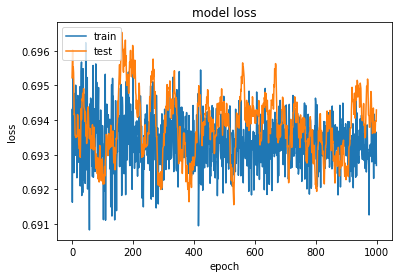

In [14]:
#summarise history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()